In [1]:
%matplotlib inline

import os
import datetime
import time
import json

import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import cross_val_score, KFold

In [10]:
## daily prices

def preprbd(x_db):
    x_db.columns = [x.lower() for x in x_db.columns.values]
    try:
        x_db.drop(['date_text','month','month day','day','year'],axis=1,inplace=True)
    except:
        pass
    x_db.drop(['open','high','low','market cap'],axis=1,inplace=True)


bit_price_d = pd.read_excel("bitcoin_data/btc_close_daily.xlsx")
preprbd(bit_price_d)
bit_price_d.rename(columns={'close':'btc_close'},inplace=True)

eth_price_d = pd.read_excel("bitcoin_data/eth_close_daily.xlsx")
preprbd(eth_price_d)
eth_price_d.rename(columns={'close':'eth_close'},inplace=True)

eth_price_d.head()

,date,eth_close,volume
0,2018-05-10,727.28,2748950000
1,2018-05-09,752.28,2877870000
2,2018-05-08,752.86,2920490000
3,2018-05-07,753.73,4316120000
4,2018-05-06,792.31,3105570000


In [4]:
## minute prices
##

bit_price = pd.read_csv('bitcoin_data/bitstampUSD_1-min_data_2012-01-01_to_2018-03-27.csv')
bit_price.columns = [x.lower() for x in bit_price.columns.values]
bit_price['date_time'] = bit_price['timestamp'].map(lambda x: datetime.datetime.fromtimestamp(x)) ## MSC timezone
bit_price.head()

,timestamp,open,high,low,close,volume_(btc),volume_(currency),weighted_price,date_time
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011-12-31 10:52:00
1,1325317980,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011-12-31 10:53:00
2,1325318040,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011-12-31 10:54:00
3,1325318100,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011-12-31 10:55:00
4,1325318160,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011-12-31 10:56:00


#### Graphs

Bitcoin price evalution 

Total points (minute data):  3273377
period:  2011-12-31 10:52:00   --   2018-03-27 03:00:00

Total points (daily data):  1839
period:  2013-04-28 00:00:00   --   2018-05-10 00:00:00


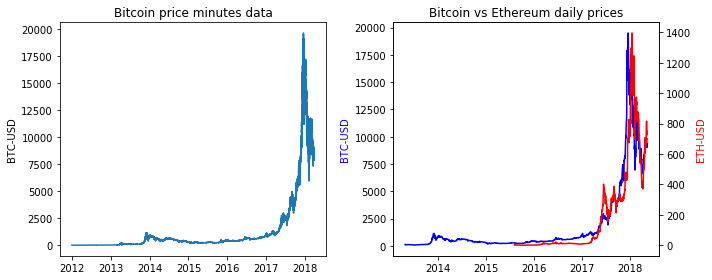

In [29]:
fig, (ax,ax1) = plt.subplots(1,2, figsize=(10, 4))

## bitcoin plot
ax.plot(bit_price['date_time'],bit_price['open'])
ax.set_ylabel('BTC-USD')
ax.set_title("Bitcoin price minutes data")

print ("Total points (minute data): ",bit_price.shape[0])
print ("period: ",np.min(bit_price['date_time']),"  --  ",np.max(bit_price['date_time']))
print ("")
print ("Total points (daily data): ",bit_price_d.shape[0])
print ("period: ",np.min(bit_price_d['date']),"  --  ",np.max(bit_price_d['date']))


## Ethereum plot
ax1.plot(bit_price_d['date'],bit_price_d['btc_close'],'b')
ax1.set_ylabel('BTC-USD',color='b')


ax2 = ax1.twinx()
ax2.plot(eth_price_d['date'],eth_price_d['eth_close'],'r')
ax2.set_ylabel('ETH-USD', color='r')
ax1.set_title("Bitcoin vs Ethereum daily prices")

plt.tight_layout()
plt.show()

#### Reading news

In [7]:
re.sub("([0-9]*),([0-9]*)","\\1\\2","ninth in terms of BTC/USD ($1,536,570) trading")

'ninth in terms of BTC/USD ($1536570) trading'

In [67]:
%%time

def clean_text(text):
    text = re.sub("<.*?>.*?</.*?>","",text)
    text = re.sub("&amp;","&",text)
    text = re.sub("\n"," ",text)
    text = re.sub("'","",text)
    text = re.sub("\$([0-9])","USD \\1",text)
    text = re.sub("([0-9])m","\\1 million",text)
    text = re.sub("([0-9])bn","\\1 billion",text)
    text = re.sub("([0-9]*),([0-9]*)","\\1\\2",text)
    text = re.sub("R&D","RnD",text)

    return text
    

## Loading text
DIR_FILE = "news_coindesk"
cd_news = []
for i_file in os.listdir(DIR_FILE):
    
    # read file
    tt = open (DIR_FILE + "/"+i_file)
    
    # process headline
    news_headline = tt.readline()
    news_headline = re.sub("\n","",news_headline)
    
    # now time for time
    news_time = tt.readline()
    news_time = datetime.datetime.strptime(news_time[0:10],"%Y-%m-%d")
    
    # news text and brief
    news_text = "".join(tt.readlines())
    try:
        news_brief = re.search("<brief>(.*?)</brief>",news_text).group(1)
    except:
        news_brief = ""
    news_text = clean_text(news_text)
    cd_news.append([news_time,news_headline,news_text])
    
    
print ("text loaded")

cd_news = pd.DataFrame(cd_news)
cd_news.columns = ['date','headline','text']

cd_news_full = cd_news.copy(deep=True)


## aggregate text and headlines on daily level
def compute_metrics(x):
    result = {'headline': " ".join(x['headline']), 'text': " ".join(x['text']),'count_news':len(x)}
    return pd.Series(result, name='metrics')

cd_news = cd_news.groupby('date').apply(compute_metrics)


cd_news.reset_index(inplace=True)
cd_news.sort_values('date',inplace=True)

## MAKE DATE SHIFT
## current news predict next date price
# cd_news['date'] = [x + datetime.timedelta(days=0) for x in cd_news['date']]

print ("metrics computed")

cd_news.head()

text loaded
metrics computed
Wall time: 5.89 s


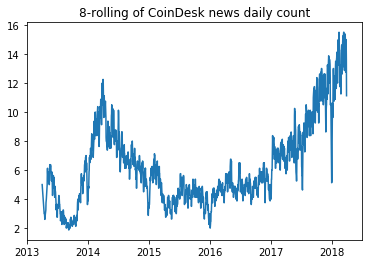

In [68]:
## Plot news count

fig, axs = plt.subplots()

aa = cd_news.rolling(8,min_periods=1)['count_news'].mean()
axs.plot(cd_news['date'],aa)
axs.title.set_text("8-rolling of CoinDesk news daily count")
plt.show()

In [257]:
##  Get daily spot price
##
all_data = bit_price_d[['date','btc_close']].copy(deep=True)
all_data.sort_values('date',ascending=True,inplace=True)
all_data.reset_index(inplace=True)
all_data.drop('index',axis=1,inplace=True)


## make returns
price = all_data['btc_close']
price_l1 = all_data['btc_close'].shift(1)
all_data['btc_return'] = (price - price_l1)/price_l1 * 100
all_data.dropna(inplace=True)


##  merge with news
all_data = all_data.merge(cd_news,how='left',on='date')
all_data.fillna('',inplace=True)


## make tfidf
tfidf = TfidfVectorizer(ngram_range=(1,2),min_df=5)
tfidif_vectors = tfidf.fit_transform(all_data['headline'])
tfidf_col_names = tfidf.get_feature_names() 

tfidif_vectors


<1799x4832 sparse matrix of type '<class 'numpy.float64'>'
	with 98720 stored elements in Compressed Sparse Row format>

In [258]:
## split into test and train
##

date_start = '2018-01-01'

filter_train = all_data['date'] < date_start
filter_test  = all_data['date'] >= date_start


matr = tfidif_vectors

dates_train =all_data.loc[filter_train,'date']
X_train = matr[np.where(filter_train)[0],]
y_train = all_data.loc[filter_train,'btc_return']

dates_test = all_data.loc[filter_test,'date']
X_test = matr[np.where(filter_test)[0],]
y_test =  all_data.loc[filter_test,'btc_return']

Text(0.5,1,'BTC return (S-S_1)/S_1')

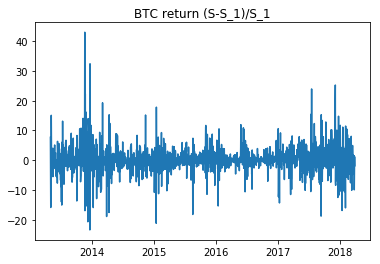

In [259]:
fig, ax = plt.subplots()
ax.plot(all_data['date'],all_data['btc_return'])
ax.set_title("BTC return (S-S_1)/S_1")

#### Ridge Model

In [260]:
def model_predict (mm,titles=["",""]):
    assert len(titles)==2
    
    y_pred = mm.predict(X_test)

    print ("RMSE test: ", mean_squared_error(y_pred,y_test))
    print ("R2 test: ",r2_score(y_pred,y_test))


    y_pred = mm.predict(X_train)

    print ("RMSE train: ",mean_squared_error(y_pred,y_train))
    print ("R2 train: ",r2_score(y_pred,y_train))

    ## Plot train data
    fig, (axs) = plt.subplots()
    axs.plot(dates_train,y_train,'b')
    axs.plot(dates_train,y_pred,'r')
    axs.set_title(titles[0])
    ## Plot test data
    y_pred = mm.predict(X_test)
    
    fig2, (axs2) = plt.subplots()
    axs2.plot(dates_test,y_test,'b')
    axs2.plot(dates_test,y_pred,'r')
    axs2.set_title(titles[1])

    fig2.autofmt_xdate()
    plt.show()

RMSE test:  34.2978462377
R2 test:  -12.3117697249
RMSE train:  6.36388550453
R2 train:  -0.374150946712


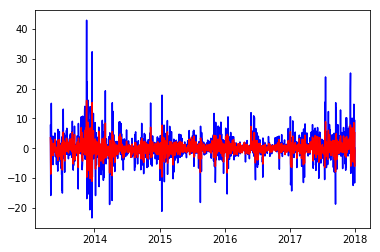

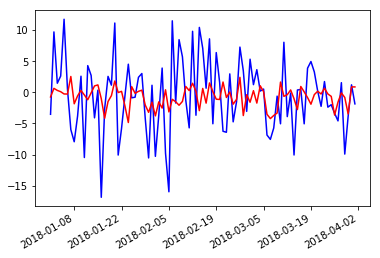

In [281]:
mm = Ridge(alpha=0.2, fit_intercept=True, normalize=True)
mm.fit(X_train,y_train)

model_predict(mm)

In [262]:
ind = np.argsort(np.abs(mm.coef_))
ind = ind[::-1]

for i_ind in ind[0:20]:
    feat = tfidf_col_names[i_ind]
    print (feat, mm.coef_[i_ind])


leading the 7.73659835742
is leading 6.11828870149
puts 5.7136223845
for bitcoins -5.39656530128
in q1 -5.30749827174
are going 4.81059540264
drops -4.79729934119
or not 4.66535958621
below -4.61063270636
price drops -4.54789759353
less 4.52546801469
cryptokitties 4.45174125323
price surges 4.44298593584
passes 4.34685837705
connection 4.26037596477
against bitcoin -4.24921012891
exchange btc 4.16785455787
south america 4.1219346301
give -4.09447641384
up blockchain 4.08005483497


34.0136955008
-22.8598971726


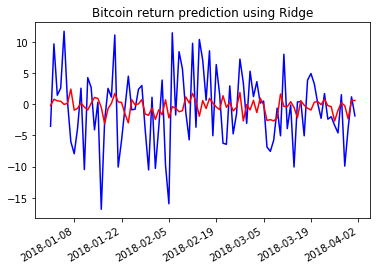

In [263]:
y_pred = mm.predict(X_test)

print (mean_squared_error(y_pred,y_test))
print (r2_score(y_pred,y_test))

fig,axs = plt.subplots()
axs.plot(dates_test,y_test,'b')
axs.plot(dates_test,y_pred,'r')
axs.set_title('Bitcoin return prediction using Ridge')
fig.autofmt_xdate()

plt.show()

#### Extra Trees

In [282]:
kf = KFold (n_splits=4)

for i_tree in np.arange(10,20,10):
    etr = ExtraTreesRegressor(n_estimators=i_tree, criterion='mse', 
                               max_depth=None, min_samples_split=2, 
                               min_samples_leaf=1, n_jobs = -1, random_state=14)

    scores = cross_val_score(etr, X_train,y_train,cv=kf,scoring ='neg_mean_squared_error')
    print (i_tree, np.mean(scores), scores)

10 -30.3713726175 [-42.27479149 -32.35627969 -14.48003964 -32.37437965]


In [277]:
%%time
etr  = ExtraTreesRegressor(n_estimators=30, criterion='mse', 
                           max_depth=None, min_samples_split=2, 
                           min_samples_leaf=1, n_jobs = -1, 
                           random_state=14, bootstrap = True, 
                           oob_score  = False)
etr.fit(X_train,y_train)

Wall time: 2.8 s


RMSE test:  32.2725123154
R2 test:  -3.24359222436
RMSE train:  3.29832261472
R2 train:  0.633541597461


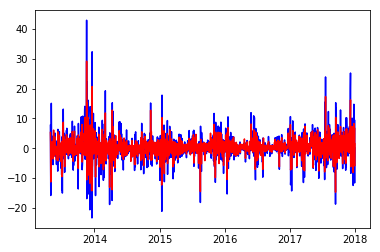

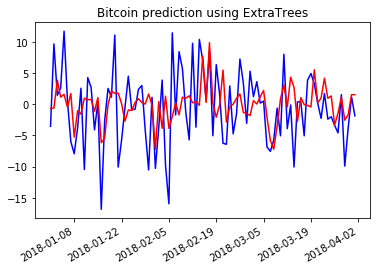

In [278]:
model_predict(etr,titles=["","Bitcoin prediction using ExtraTrees"])

In [243]:
imp = etr.feature_importances_
ind = np.argsort(imp)
ind = ind[::-1]

for i_ind in ind[0:20]:
    feat = tfidf_col_names[i_ind]
    print (feat, imp[i_ind])


below 0.0179996537037
drops 0.0149376849856
passes 0.0143869343797
decline 0.0131756356646
hearing 0.0111058354404
secure 0.0110528657613
food 0.00934998186026
high 0.00927611368968
gets 0.00915653537975
buys 0.00842454917586
sells 0.00815382090315
leading 0.00731924303976
university 0.00715869651049
demand 0.00681507436705
than 0.00669111499084
freezes 0.00664422561758
investigation 0.00618977422473
sale 0.00561648306716
blasts 0.00521450196244
accept 0.00520537951931


In [87]:
## search for text
##

for i_hh in all_data['text']:
    aa = re.search('012',i_hh,re.IGNORECASE)
    if aa is not None:
        print (i_hh,"\n")

  Can bitcoin conquer Argentina? It's a question that is being given increasing validity by major media outlets like The New York Times and The Economist, and it's easy to see why. Numerical and anecdotal evidence suggest that if bitcoin will prove popular as a currency anywhere, it should in Argentina. According to the Bitcoin Market Potential Index (BMPI), which ranks bitcoin's potential utility across 177 countries, Argentina is the most likely country to adopt the digital currency. It's economy is one of the most problematic globally, boasting annual inflation of approximately 35%. In theory, this means monetary stability in Argentina is particularly weak. In practice, it has led to a thriving black market for alternative means of exchange. Small, fervent user base The prominence of bitcoin in Argentina isn't in dispute, with interviewees telling CoinDesk its adoption is comparable to that seen in New York or San Francisco. Tech entrepreneur Joan Cwaik, for example, estimates Argen

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [108]:
i_col = np.where([x == '512' for x in tfidf_col_names])[0]
i_col = i_col[0]

print (tfidf_col_names[i_col])
aa = pd.DataFrame(tfidif_vectors[:,i_col].todense())
aa.columns = ["word"]
aa = aa.query("word>0")
print (aa)

512
          word
996   0.010503
1692  0.005265
1710  0.006876
1713  0.006550
1754  0.005761
1760  0.004892
1761  0.005500
1767  0.009441


In [206]:
all_data.loc[1761,'text']

'  Signs of bull market exhaustion in the bitcoin market may be having a knock-on effect across cryptocurrencies in general. All of the top 100 cryptocurrencies by market capitalization - bar nano dentacoin and tether - are in the red today according to CoinMarketCap data. Bitcoin (BTC) has dropped over 8 percent in the last 24 hours as was indicated by the bearish reversal pattern on the daily charts and head-and-shoulders breakdown on the hourly chart. As of writing BTC had dropped to USD 9958 - down 16.72 percent from the recent high of USD 11958 hit on Feb. 20. if("undefined"==typeof window.datawrapper)window.datawrapper={};window.datawrapper["4LVL8"]={}window.datawrapper["4LVL8"].embedDeltas={"100":512.0208339999999"200":485.020834"300":459.020834"400":459.020834"500":459.020834"700":459.020834"800":459.020834"900":459.020834"1000":459.020834}window.datawrapper["4LVL8"].iframe=document.getElementById("datawrapper-chart-4LVL8")window.datawrapper["4LVL8"].iframe.style.height=window.

#### LDA


In [294]:
### https://rstudio-pubs-static.s3.amazonaws.com/79360_850b2a69980c4488b1db95987a24867a.html
##

from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
import gensim

tokenizer = RegexpTokenizer(r'\w+')

# create English stop words list
en_stop = get_stop_words('en')

# Create p_stemmer of class PorterStemmer
p_stemmer = PorterStemmer()


C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [295]:
%%time

texts = []
# loop through document list
for i in cd_news_full['text']:
    
    # clean and tokenize document string
    raw = i.lower()
    tokens = tokenizer.tokenize(raw)

    # remove stop words from tokens
    stopped_tokens = [i for i in tokens if not i in en_stop]
    
    # stem tokens
    stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
    
    # add tokens to list
    texts.append(stemmed_tokens)
print ("done steming, tokenization and etc")
    
# turn our tokenized documents into a id <-> term dictionary
dictionary = corpora.Dictionary(texts)
print ("Now I have dictionary")

# convert tokenized documents into a document-term matrix
corpus = [dictionary.doc2bow(text) for text in texts]
print ("Corpus initialization done")

# generate LDA model
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=20, id2word = dictionary, passes=20)
ldamodel.save('nlp/lda')
print ("Finished lda model")

done steming, tokenization and etc
Now I have dictionary
Corpus initialization done


NameError: name 'lda' is not defined

In [307]:
ldamodel.print_topics(20)

[(0,
  '0.055*"bitcoin" + 0.016*"event" + 0.015*"will" + 0.010*"said" + 0.010*"startup" + 0.009*"confer" + 0.009*"founder" + 0.008*"ceo" + 0.007*"compani" + 0.006*"panel"'),
 (1,
  '0.042*"bitcoin" + 0.021*"develop" + 0.015*"network" + 0.013*"fork" + 0.012*"block" + 0.010*"will" + 0.009*"transact" + 0.008*"support" + 0.008*"chang" + 0.007*"core"'),
 (2,
  '0.033*"bitcoin" + 0.011*"market" + 0.011*"will" + 0.011*"currenc" + 0.008*"valu" + 0.008*"money" + 0.007*"like" + 0.007*"can" + 0.006*"cryptocurr" + 0.006*"bank"'),
 (3,
  '0.033*"bitcoin" + 0.028*"gox" + 0.027*"mt" + 0.025*"tax" + 0.017*"japan" + 0.010*"japanes" + 0.010*"exchang" + 0.009*"ir" + 0.007*"us" + 0.007*"petro"'),
 (4,
  '0.028*"foundat" + 0.022*"vote" + 0.020*"member" + 0.015*"bitcoin" + 0.014*"etf" + 0.012*"board" + 0.012*"insur" + 0.010*"elect" + 0.010*"hyperledg" + 0.009*"will"'),
 (5,
  '0.071*"rippl" + 0.040*"xrp" + 0.026*"bank" + 0.020*"payment" + 0.011*"swift" + 0.010*"network" + 0.010*"remitt" + 0.010*"use" + 0.01

In [336]:
all_texts = []
NUM_TOPICS = 20

for i_text in range(len(corpus)):
    aa = np.zeros(NUM_TOPICS)
    for i_topic in ldamodel[corpus[i_text]]:
        aa[i_topic[0]] = i_topic[1]
    all_texts.append(aa)
    
all_texts = pd.DataFrame(all_texts)
all_texts.columns = ['topic_%02d' % x for x in range(NUM_TOPICS)]
all_texts['date'] = cd_news_full['date']

In [402]:
## LDA metric
##
topic_metrics = all_texts.groupby('date').sum()
topic_metrics.reset_index(inplace= True)
topic_metrics['date'] = [x + datetime.timedelta(days=1) for x in cd_news['date']]


##  Get daily spot price
##
all_lda = bit_price_d[['date','btc_close']].copy(deep=True)
all_lda.sort_values('date',ascending=True,inplace=True)
all_lda.reset_index(inplace=True)
all_lda.drop('index',axis=1,inplace=True)


## make returns
price = all_data['btc_close']
price_l1 = all_data['btc_close'].shift(1)
all_lda['btc_return'] = (price - price_l1)/price_l1 * 100
all_lda.dropna(inplace=True)


##  merge with news
all_lda = all_lda.merge(topic_metrics,how='left',on='date')
all_lda.fillna(0,inplace=True)
all_lda

,date,btc_close,btc_return,topic_00,topic_01,topic_02,topic_03,topic_04,topic_05,topic_06,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,2013-04-29,144.54,7.696893,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2013-04-30,139.00,-3.832849,0.077702,0.258868,0.742656,0.029317,0.060616,0.000000,0.096072,...,0.066846,0.743522,0.159545,0.000000,0.028238,1.142656,0.082836,1.325283,0.114384,0.065056
2,2013-05-01,116.99,-15.834532,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,2013-05-02,105.21,-10.069237,0.013812,0.071540,0.713332,0.463088,0.000000,0.059245,0.070621,...,0.000000,2.170360,0.127192,0.047842,0.536017,1.390718,0.000000,0.236219,0.166446,0.189369
4,2013-05-03,97.75,-7.090581,0.201404,0.373249,0.933697,0.174285,0.000000,0.107180,0.034843,...,0.340072,1.613404,0.318149,0.028890,0.063554,1.986432,0.064838,1.518124,0.189595,0.138918
5,2013-05-04,112.50,15.089514,1.100405,0.181043,0.869400,0.563615,0.016320,0.021092,0.301279,...,0.000000,0.581009,0.096280,0.101407,0.133237,1.378890,0.112797,0.317450,0.023713,0.033000
6,2013-05-05,115.91,3.031111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,2013-05-06,112.30,-3.114485,0.000000,0.000000,0.404786,0.000000,0.000000,0.023323,0.028691,...,0.000000,0.145017,0.043411,0.000000,0.064140,0.135825,0.000000,0.022300,0.000000,0.000000
8,2013-05-07,111.50,-0.712378,0.057244,0.058879,0.615798,0.000000,0.000000,0.000000,0.000000,...,0.020647,0.511822,0.000000,0.000000,0.043739,0.678060,0.000000,0.024879,0.068860,0.000000
9,2013-05-08,113.57,1.856502,0.734938,0.062830,1.293520,0.098880,0.033401,0.000000,0.058745,...,0.000000,0.182886,0.011097,0.024696,0.022272,1.610585,0.030734,0.240034,0.170278,0.000000


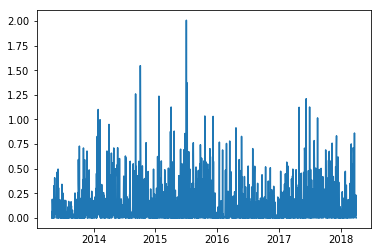

In [403]:
plt.plot(all_lda['date'],all_lda.iloc[:,22])

In [404]:

date_start = '2018-01-01'

filter_train = all_lda['date'] < date_start
filter_test  = all_lda['date'] >= date_start


matr = tfidif_vectors

dates_train =all_lda.loc[filter_train,'date']
X_train = all_lda.iloc[np.where(filter_train)[0],3:]
y_train = all_lda.loc[filter_train,'btc_return']

dates_test = all_lda.loc[filter_test,'date']
X_test = all_lda.iloc[np.where(filter_test)[0],3:]
y_test =  all_lda.loc[filter_test,'btc_return']

RMSE test:  36.4175415324
R2 test:  -835.00718202
RMSE train:  19.4540988117
R2 train:  -225.457113586


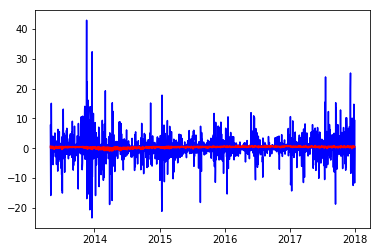

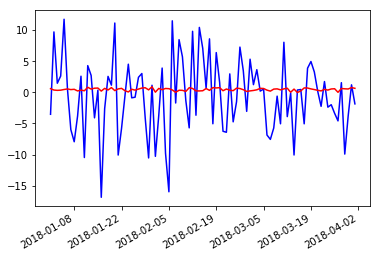

In [406]:
mm = Ridge(alpha=1, fit_intercept=True, normalize=True)
mm.fit(X_train,y_train)

model_predict(mm)

RMSE test:  43.4000656267
R2 test:  -16.1180043346
RMSE train:  3.41193143186
R2 train:  0.571775559859


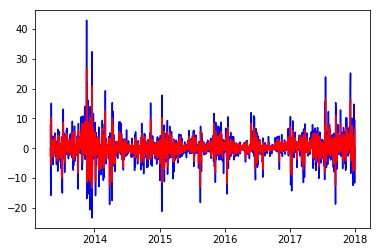

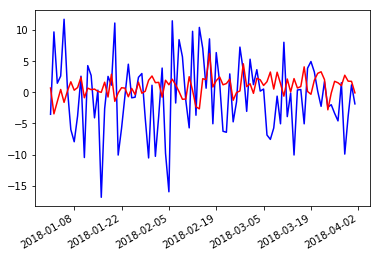

In [407]:
etr  = ExtraTreesRegressor(n_estimators=50, criterion='mse', 
                           max_depth=None, min_samples_split=2, 
                           min_samples_leaf=1, n_jobs = -1, 
                           random_state=14, bootstrap = True, 
                           oob_score  = False)
etr.fit(X_train,y_train)

model_predict(etr)